**Objectif**

Dans ce fichier, notre objectif est de rendre nos données stationnaires. Ainsi, nous avons suivi les étapes suivantes : 

**Démarche**

1) Analyse graphique de la stationnarité
2) identification de l'origine de la non-stationnarité
3) Rendre les séries temporelles stationnaires
4) Analyse de l'auto-corrélation
5) Analyse de la volatilité des variables explicatives
6) Différenciation de second ordre
7) Combinaison des données stationnaires
8) Combiner les indicateurs de récession aux données stationnaires
9) Graphiques des variables originales et stationnaires côte à côte
10) Exporter la série stationnaire

**Conclusion**

La conclusion de ce fichier est que que : 
- Le target, le taux de chômage (UNRATE) est déjà stationnaire. Il a été différencié toutefois puisqu'on voulait expliquer le taux de croissance du chômage dans ce projet.
- Voici les variables assurément stationnaires avec l'ordre 1 : 
    - INDPRO :activité industrielle 
    - RPI : revenu personnel réel des ménages
    - S&P 500 : indice boursier représentatif du marché actions américain
    - DPCERA3M086SBEA : dépenses de consommation réelles.
    - TB3MS : taux d’intérêt à court terme
- Pour avoir une explication de chaque variable en termes de croissance, le TB3MS (un taux) a été différencié en point contrairement aux autres avec un log.
- A cause d'une mémoire longue présente dans les variables suivantes ou exceptionnellement pour sa volatilité (OILPRICEx), une seconde différenciation a été nécessaire : 
    - BUSLOANS : prêts bancaires aux entreprises
    - CPIAUCLS : indice des prix à la consommation (inflation)
    - M2SL : masse monétaire au sens large
    - OILPRICEx : prix du baril de pétrole
- USREC indique la présence d'une période de récision ou non

**Next action :** 
splitter les données TRAIN-TEST

# Packages

In [88]:
import pandas as pd
import pandas_datareader.data as web
from pathlib import Path
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime

In [89]:
import importlib
import eda_utils

importlib.reload(eda_utils)
from eda_utils import *

# Importer les données

In [90]:
project_root = Path.cwd().parent
project_root

data_path = (
    project_root
    / "1_data"
    / "processed"
    / "features"
    / "unemployment_features_raw.csv"
)

data_path

WindowsPath('d:/Portofolio Data science/Time Series/Explainable_AI_Forecast_and_explain_the_Unemployment_of_USA/1_data/processed/features/unemployment_features_raw.csv')

In [91]:
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
df.head()

,BUSLOANS,CPIAUCSL,DPCERA3M086SBEA,INDPRO,M2SL,OILPRICEX,RPI,SP500,TB3MS,UNRATE,USREC
date,,,,,,,,,,,
1959-01-01,35.2130,29.01,15.188,21.9998,286.6,3.00,2583.560,55.62,2.82,6.0,0.0
1959-02-01,35.2201,29.00,15.346,22.4306,287.7,3.00,2593.596,54.77,2.70,5.9,0.0
1959-03-01,35.1304,28.97,15.491,22.7538,289.2,2.97,2610.396,56.16,2.80,5.6,0.0
1959-04-01,35.5581,28.98,15.435,23.2384,290.1,2.97,2627.446,57.10,2.95,5.2,0.0
1959-05-01,36.3064,29.04,15.622,23.5885,292.2,2.97,2642.720,57.96,2.84,5.1,0.0


## 1. Analyse graphique de stationnarité

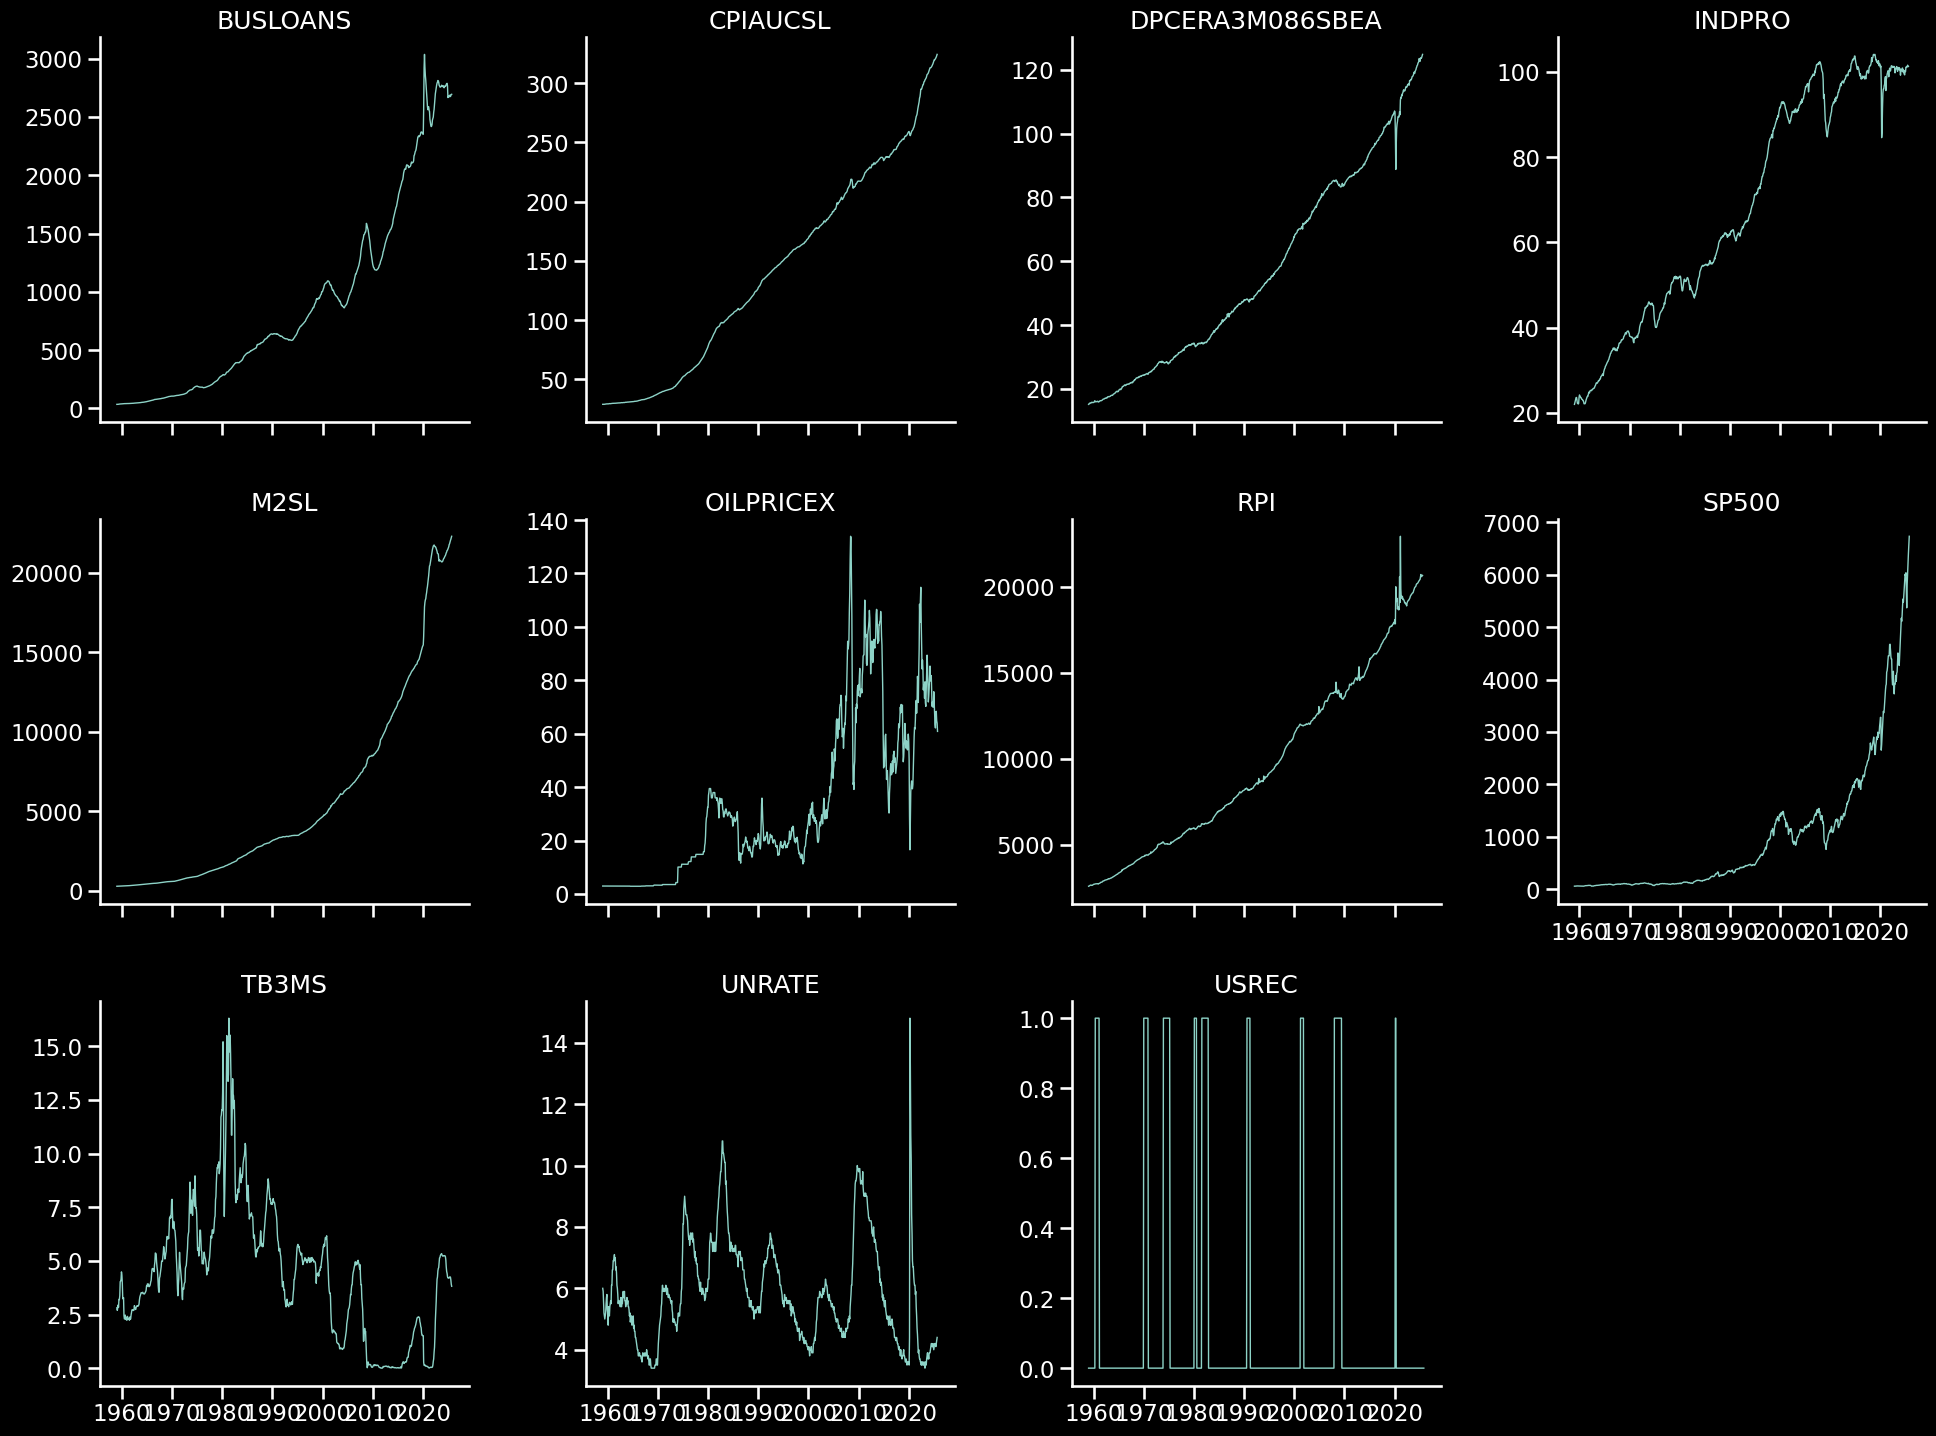

In [92]:
df_long_orig = plot_original_series(df)

Vu que le taux de chômage et le monthly treasure bill rate sont en pourcentage, ils sont très proche de l'état stationnaire (moyenne = 0  et variance stable). Le monthly treasure bill est un peu volatile. La variance commence à bouger sur l'OIL price tandis que la tendance à la hausse est la règle pour le reste. 

En clair, nos données sont toutes à priori non-stationnaires. Il faut cependant justifier cette analyse par des tests de stationnarités et identifier aussi l'origine de la non-stationnarité. 

## 2) Identifier l'origine de la non-stationnarité

### Workflow — Test Dickey–Fuller (Modèle 1)

---

**Modèle à estimer**

$$
\Delta y_t = c + \beta_1 t + \gamma y_{t-1} + \varepsilon_t
$$

---

**Étape 1 — Tester la présence d’une racine unitaire**

Hypothèse :

$$
H_0 : \gamma = 0
$$

→ Test Dickey–Fuller (seuil critique = *tau3*)

---

### CAS A — Racine unitaire présente
Décision : non-rejet de H₀ : γ = 0
Conséquence : présence d’une racine unitaire
Valeur de la racine : φ₁ = 1

**A1 — Tester si au moins un des paramètres est ≠ 0**

Test de Fisher :

$$
H_0^2 : c = \gamma = \beta_1 = 0
$$

- **Si rejet de \(H_0^2\)** :

  Variation stationnaire :

  $$
  \Delta y_t = c + \beta_1 t + \varepsilon_t
  $$

  Conclusion :

  $$
  y_t \sim I(1)
  $$

- **Si non-rejet de \(H_0^2\)** :

  Estimation du **Modèle 2** :

  $$
  \Delta y_t = c + \gamma y_{t-1} + \varepsilon_t
  $$

---

### CAS B — Pas de racine unitaire
Décision : rejet de H₀ : γ = 0
Conséquence : absence de racine unitaire
Valeur de la racine : |φ₁| < 1

**B1 — Tester la significativité du trend**

Test Student :

$$
H_0 : \beta_1 = 0
$$

- **Si rejet de \(H_0\)** :

  $$
  y_t \text{ est TS avec trend}
  $$

  $$
  \Delta y_t \text{ est TS}
  $$

- **Si non-rejet de \(H_0\)** :

  Estimation du **Modèle 2** :

  $$
  \Delta y_t = c + \gamma y_{t-1} + \varepsilon_t
  $$

---

In [93]:
rapport_stationnarite = analyse_stationnarite(df)
rapport_stationnarite

,ADF stat (tau3),ADF p-value,lags used (ADF),beta1,beta1 p-value,phi2_F,phi2_pval,opt_diff_lag,best_diff_lag,Nature,Conclusion
BUSLOANS,-1.318022,0.883399,4,0.011849,0.04967,5.088127,0.00171,1,1,Integrated I(1),diff(1)
CPIAUCSL,-1.563429,0.806426,15,0.000938,0.059494,6.098451,0.000421,1,6,Integrated I(1),diff(1)
DPCERA3M086SBEA,-0.457154,0.985022,11,0.000602,0.277688,16.773131,0.0,1,1,Integrated I(1),diff(1)
INDPRO,-2.080973,0.556734,11,0.000993,0.06038,3.787682,0.010268,1,1,Integrated I(1),diff(1)
M2SL,0.651525,0.99702,17,0.016799,0.211176,6.265755,0.000334,1,12,Integrated I(1),diff(1)
OILPRICEX,-3.402326,0.051078,6,0.002666,0.005199,3.951229,0.008204,1,1,Integrated I(1),diff(1)
RPI,-0.458905,0.984961,20,0.162572,0.305725,12.16733,0.0,1,3,Integrated I(1),diff(1)
SP500,4.4144,1.0,21,-0.021038,0.195548,12.340302,0.0,1,3,Integrated I(1),diff(1)
TB3MS,-2.998135,0.132603,20,-0.000122,0.06056,3.037036,0.028468,1,12,Integrated I(1),diff(1)
UNRATE,-3.449634,0.045101,2,-0.000027,0.67419,3.992948,0.007745,1,1,Stationary (no significant trend),none (already stationary)


## Origine de la non stationnarité : 
- Contrairement à toutes les séries temporelles, le taux de chômage est stationnaire à niveau. il n'a pas aussi une tendance significative. Ces résultats sont normaux, puisque le taux de chômage est un taux.
- Dans n'importe quelle variable predicators, au moins un des termes déterministes suivantes causent la non-stationnarité : 
    - la tendance puisqu'on s'aperçoit que la majorité des séries temporelles augmentent dans le temps ; 
    - le drift puisque le niveau moyen est tout simplement non nul même si on ne voit pas clairement une tendance visible. 
- Si on revient sur le graphique pour précier, voici les séries temporelles dont la tendance explique la non-stationnarité :
    - Busloans : Commercial and Industrial Loans, billions of U.S. dollars ; 
    - CPIAUCL : Consumer Price Index for All Urban Consumers, index (1982–84 = 100) ; 
    - DPCERA3M086SBEA: Real Personal Consumption Expenditures, billions of chained 2012 U.S. dollars (SAAR) ; 
    - M2SL : M2 Money Stock, billions of U.S. dollars ; 
    - RPI : Real Personal Income, billions of chained 2012 U.S. dollars (SAAR) ; 
    - S&P500 : Standard & Poor’s 500 Index, index level (price index, no dividends).
    
- Pour le TB3MS, c'est plutôt le drift (au sens restreint çi-dessus) qui explique sa non stationnarité. TB3MS : 3-Month Treasury Bill Rate, percent per annum (yield).

- Pour le prix du baril de pétrol OILPRICEx, la série temporelle est déjà stationnaire autour d'une tendance. 

Le reste ne sont pas stationnaires. La différenciation d'ordre 1 ne signifie pas que le nombre de lag optimal est égal à 1. Nous pouvons encore appliquer un lag = 1, 3, 6, 12 mais avec une seule différenciation.

# Que faire? 
1. Cible (UNRATE)
- Objectif : prédire la variation annuelle du chômage.
- Transformation : Δ12 UNRATE (même si stationnaire en niveau).
- Justification : cohérent avec l’horizon de prévision (12 mois).

3. Pourquoi Δ3 pour les prédicteurs ?
- Stationnarité garantie.
- Compromis bruit / signal : Δ1 trop volatil, Δ12 trop lent.
- Pertinence économique : capte des signaux trimestriels anticipant l’évolution annuelle du chômage.
- et surtout recommandé dans la base FRED-MD (McCracken & Ng, 2016) pour la plupart des séries.

2. Cas spécifiques
- TB3MS (taux d’intérêt) : le taux ne se logge pas ; il faut faire une variation trimestrielle en points.
- Les autres séries vont être transformées en logarithmes. Pourquoi? C'est pour obtenir des séries stationnaires mais aussi interprétables économiquement en termes de croissance. 
- OilpriceX : Même si cette variable est déjà stationnaire, il faut l'appliquer le log différence pour un souci d'interprétation.


Résumé :
- Target : Δ12 UNRATE.
- Features : Δ3 (niveau pour TB3MS, log-diff pour les autres).

# 3) Rendre les séries stationnaires

In [94]:
rules = {
    "UNRATE":   {"method": "diff",    "lags": 12},  # chômage Δ12
    "TB3MS":    {"method": "diff",    "lags": 3},   # T-bill Δ3
    "_default": {"method": "logdiff", "lags": 3},   # autres Δlog(3)
}

In [95]:
df_stationary, adf_summary, meta = stationarize_by_rules(
    df,
    rules=rules,
    skip_cols=("USREC",),
    adf_regression="ct",
    dropna_all=True
)

report_stationary = build_stationarity_report(adf_summary, meta)
print(report_stationary)

                         method  ADF stat       p-value  usedlag(ADF)  nobs  \
series                                                                        
BUSLOANS         logdiff(lag=3) -5.292760  5.834733e-05          20.0   778   
CPIAUCSL         logdiff(lag=3) -3.606771  2.927849e-02          20.0   777   
DPCERA3M086SBEA  logdiff(lag=3) -5.828412  5.001033e-06          18.0   778   
INDPRO           logdiff(lag=3) -6.912563  2.226178e-08          19.0   777   
M2SL             logdiff(lag=3) -5.259452  6.755653e-05          19.0   779   
OILPRICEX        logdiff(lag=3) -6.057427  1.662502e-06          21.0   777   
RPI              logdiff(lag=3) -7.250088  3.813889e-09          20.0   776   
SP500            logdiff(lag=3) -6.209195  7.898712e-07          21.0   777   
TB3MS               diff(lag=3) -6.237001  6.884032e-07          21.0   777   
UNRATE             diff(lag=12) -5.658336  1.112215e-05          13.0   775   
USREC            none (skipped)       NaN           

Toutes les séries temporelles sont stationnaires. Mais l'idée de stationnarisation ne s'arrête pas ici, posons-nous la question suivante :
- La série a-t-elle une mémoire courte ou longue ?
Cette question est essentielle, car la différenciation est censée supprimer les relations à long terme (tendances). Si des dépendances persistent sur de nombreux retards (lags), cela signifie que la série n’a pas été suffisamment différenciée ou qu’une composante structurelle subsiste.

Ce qui amène à différencier encore une fois la série temporelle. 

# 4) Analyse del'autocorrélation

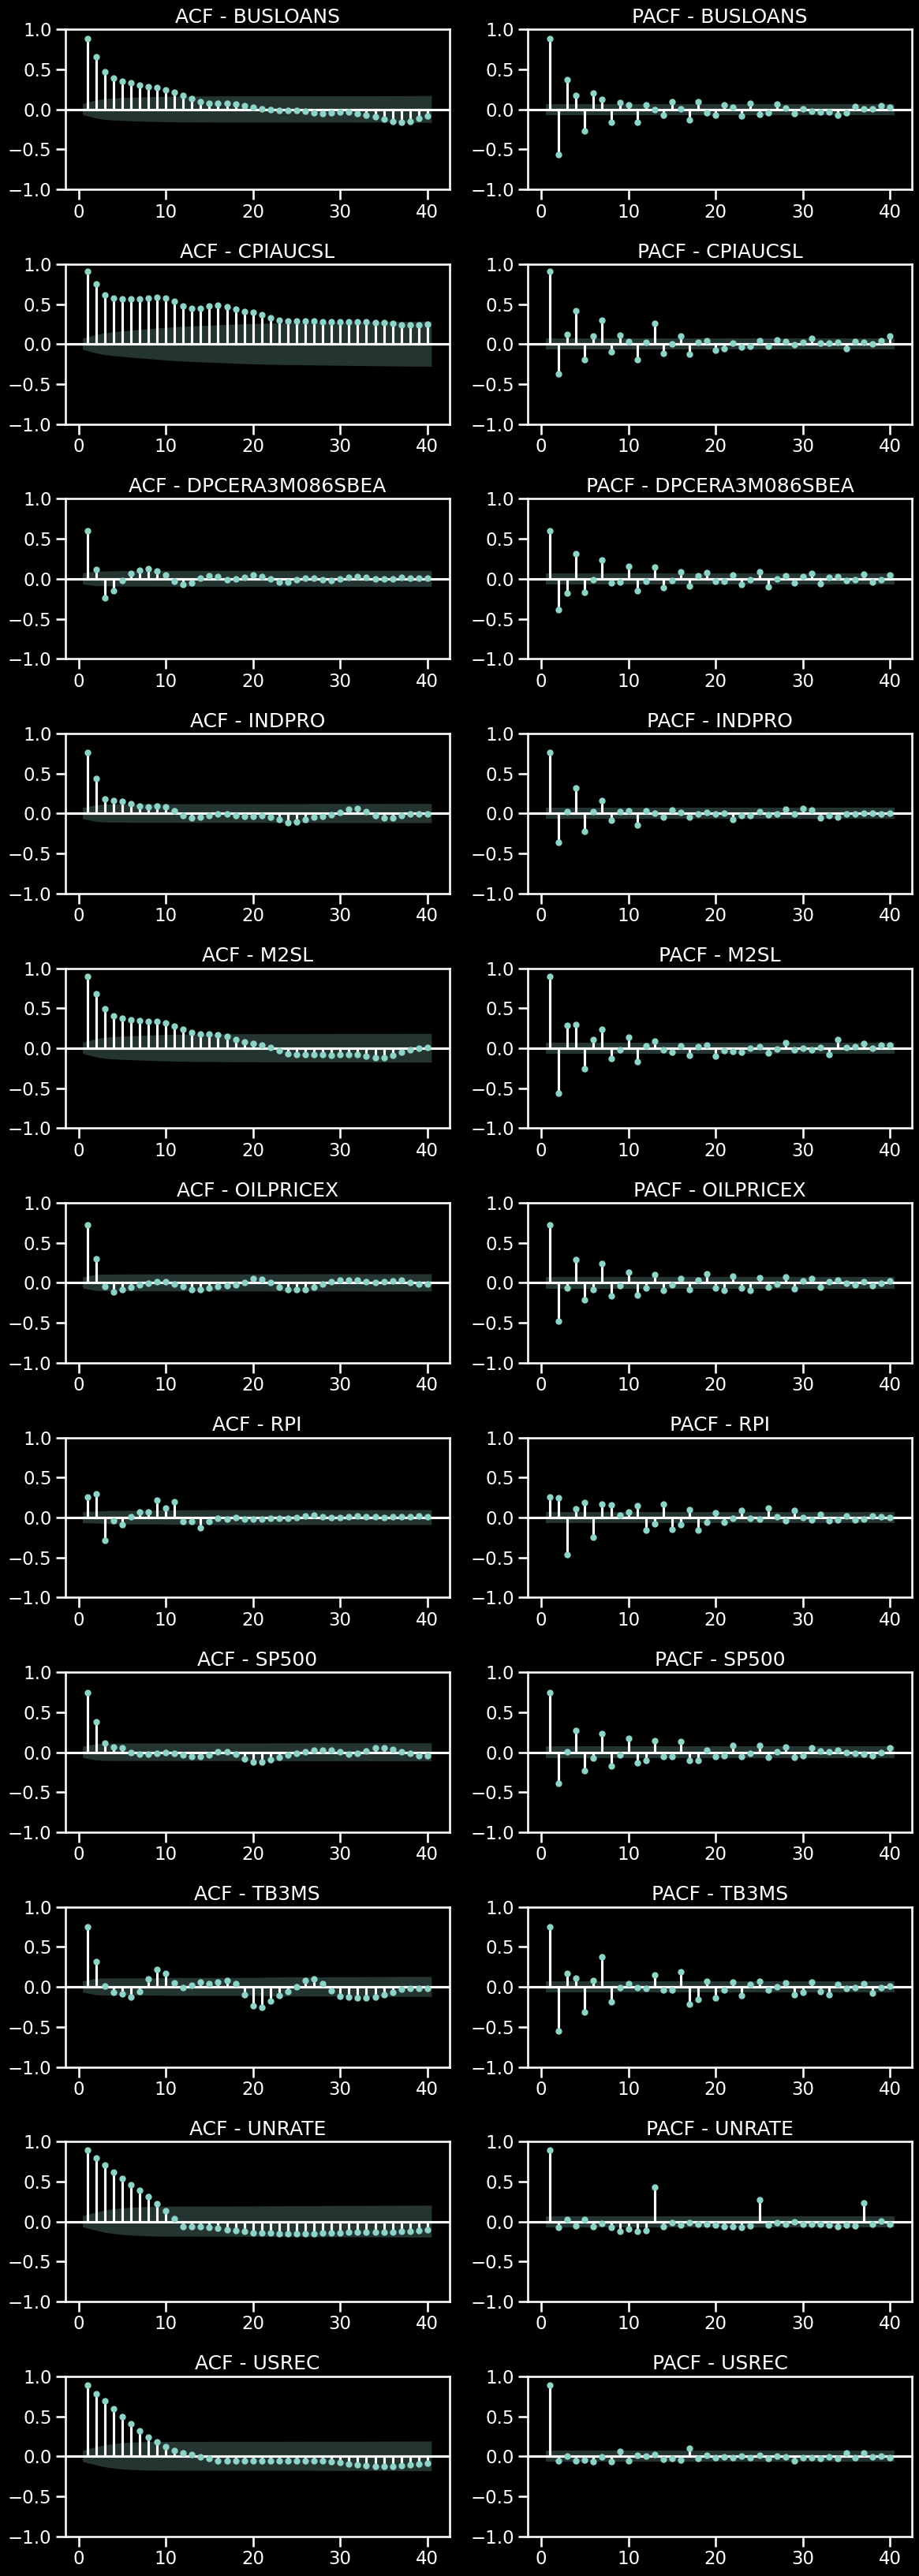

In [96]:
plot_acf_pacf_stationary(df_stationary)

**Règle d'interprétation**
- Mémoire (via l’ACF)
    - ACF qui décroît rapidement → mémoire courte
    - ACF qui décroît lentement → mémoire longue

- Lecture conjointe ACF / PACF
    - PACF avec quelques pics nets et ACF qui décroît → dépendance concentrée sur peu de retards
    - ACF avec quelques pics nets et PACF qui décroît → influence marquée de chocs passés
    - ACF et PACF qui décroissent progressivement → structure plus persistante et étalée dans le temps

- Règle générale
    - Mémoire courte : dépendance limitée dans le temps.
    - Mémoire longue : persistance importante et durable des effets passés.

**interprétation**

- L’ACF/PACF met en évidence une mémoire longue pour UNRATE, BUSLOANS, M2SL et CPIAUSL. Ces séries montrent une forte persistance des valeurs passées. Elles peuvent nécessiter une différenciation supplémentaire.

- À l’inverse, TB3MS, RPI, INDPRO, DPCE, S&P500 et OILPRICEx présentent une mémoire courte. Leur dépendance temporelle s’atténue rapidement.

**Suite**

Faisons une analyse de volatilité maintenant si on ressent quand même la nécessité de modifier certains séries.

# Analyse de la volatilité des predicators

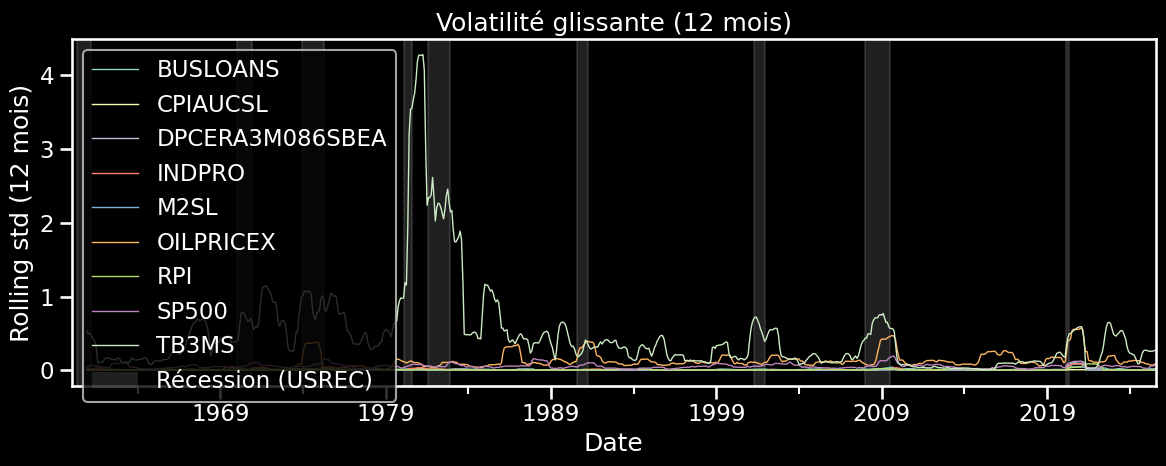

In [97]:
plot_rolling_volatility(
    df_stationary,
    window=12,
    exclude_cols=("UNRATE", "USREC")
)

**Règle de volatilité**

une série est d’autant plus volatile que son rolling standard deviation varie beaucoup et atteint souvent des amplitudes élevées. 

Le TB3MS est la plus volatile parce que les taux courts réagissent directement et brutalement aux politiques monétaires et aux crises. C'est le cas le plus visible vers le deuxième choc pétrolier des années 80.

Nous n'allons pas différencier pour la 2nd fois le taux TB3MS, c'est pour avoir une interprétation économique en termes de croissance. 

Enlevons TB3MS dans le graphique pour voir la volatilité des autres prédicateurs.

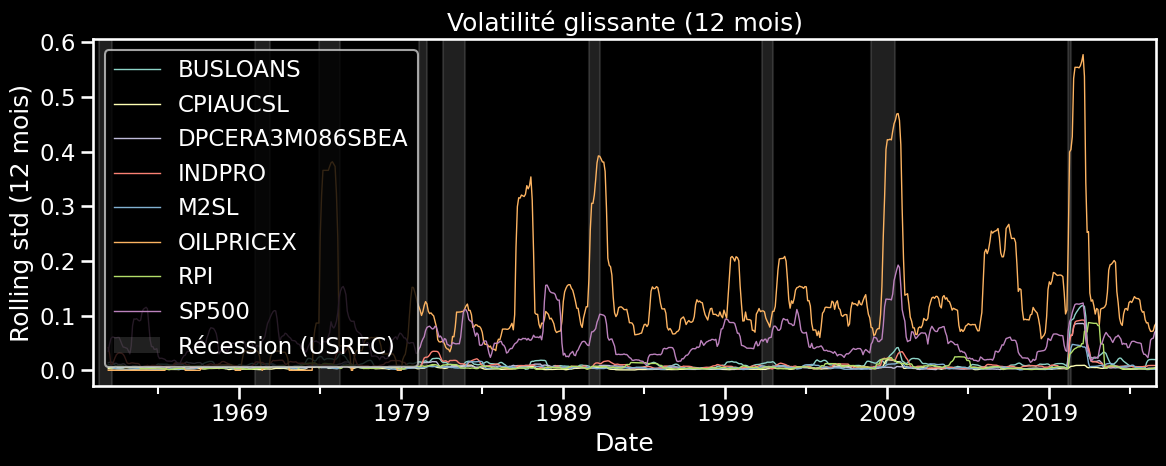

In [98]:
plot_rolling_volatility(
    df_stationary,
    window=12,
    exclude_cols=("UNRATE", "TB3MS", "USREC")
)

**interprétation**

Le graphique montre que OILPRICEx est la série la plus volatile, avec des pics de forte amplitude et des variations rapides. Le prix du pétrole réagit immédiatement aux chocs mondiaux, ce qui génère une forte persistance des chocs. Une seconde différenciation logarithmique est donc utilisée pour atténuer cette persistance et améliorer la robustesse des prévisions hors échantillon.

**2nd différenciation pour**
- OILPRICEx
- BUSLOANS
- M2SL
- CPIAUSL

# 6) Différenciation de second ordre

In [ ]:
rules = {
    # règles spécifiques inchangées
    "UNRATE":   {"method": "diff",    "lags": 12},  # chômage Δ12
    "TB3MS":    {"method": "diff",    "lags": 3},   # T-bill Δ3

    # surcharges : 2e différenciation log pour ces séries
    "OILPRICEx": {"method": "logdiff", "lags": 3},
    "BUSLOANS":  {"method": "logdiff", "lags": 3},
    "M2SL":      {"method": "logdiff", "lags": 3},
    "CPIAUCSL":  {"method": "logdiff", "lags": 3},

    # règle par défaut (toutes les autres)
    "_default": {"method": "logdiff", "lags": 3},
}

In [100]:
df_stationary, adf_summary, meta = stationarize_by_rules(
    df,
    rules=rules,
    skip_cols=("USREC",),
    adf_regression="ct",
    dropna_all=True
)

report_stationary = build_stationarity_report(adf_summary, meta)
print(report_stationary)

                         method  ADF stat       p-value  usedlag(ADF)  nobs  \
series                                                                        
BUSLOANS         logdiff(lag=3) -5.292760  5.834733e-05          20.0   778   
CPIAUCSL         logdiff(lag=3) -3.606771  2.927849e-02          20.0   777   
DPCERA3M086SBEA  logdiff(lag=3) -5.828412  5.001033e-06          18.0   778   
INDPRO           logdiff(lag=3) -6.912563  2.226178e-08          19.0   777   
M2SL             logdiff(lag=3) -5.259452  6.755653e-05          19.0   779   
OILPRICEX        logdiff(lag=3) -6.057427  1.662502e-06          21.0   777   
RPI              logdiff(lag=3) -7.250088  3.813889e-09          20.0   776   
SP500            logdiff(lag=3) -6.209195  7.898712e-07          21.0   777   
TB3MS               diff(lag=3) -6.237001  6.884032e-07          21.0   777   
UNRATE             diff(lag=12) -5.658336  1.112215e-05          13.0   775   
USREC            none (skipped)       NaN           

# 9) Graphiques des variables originales et stationnaires côte à côte

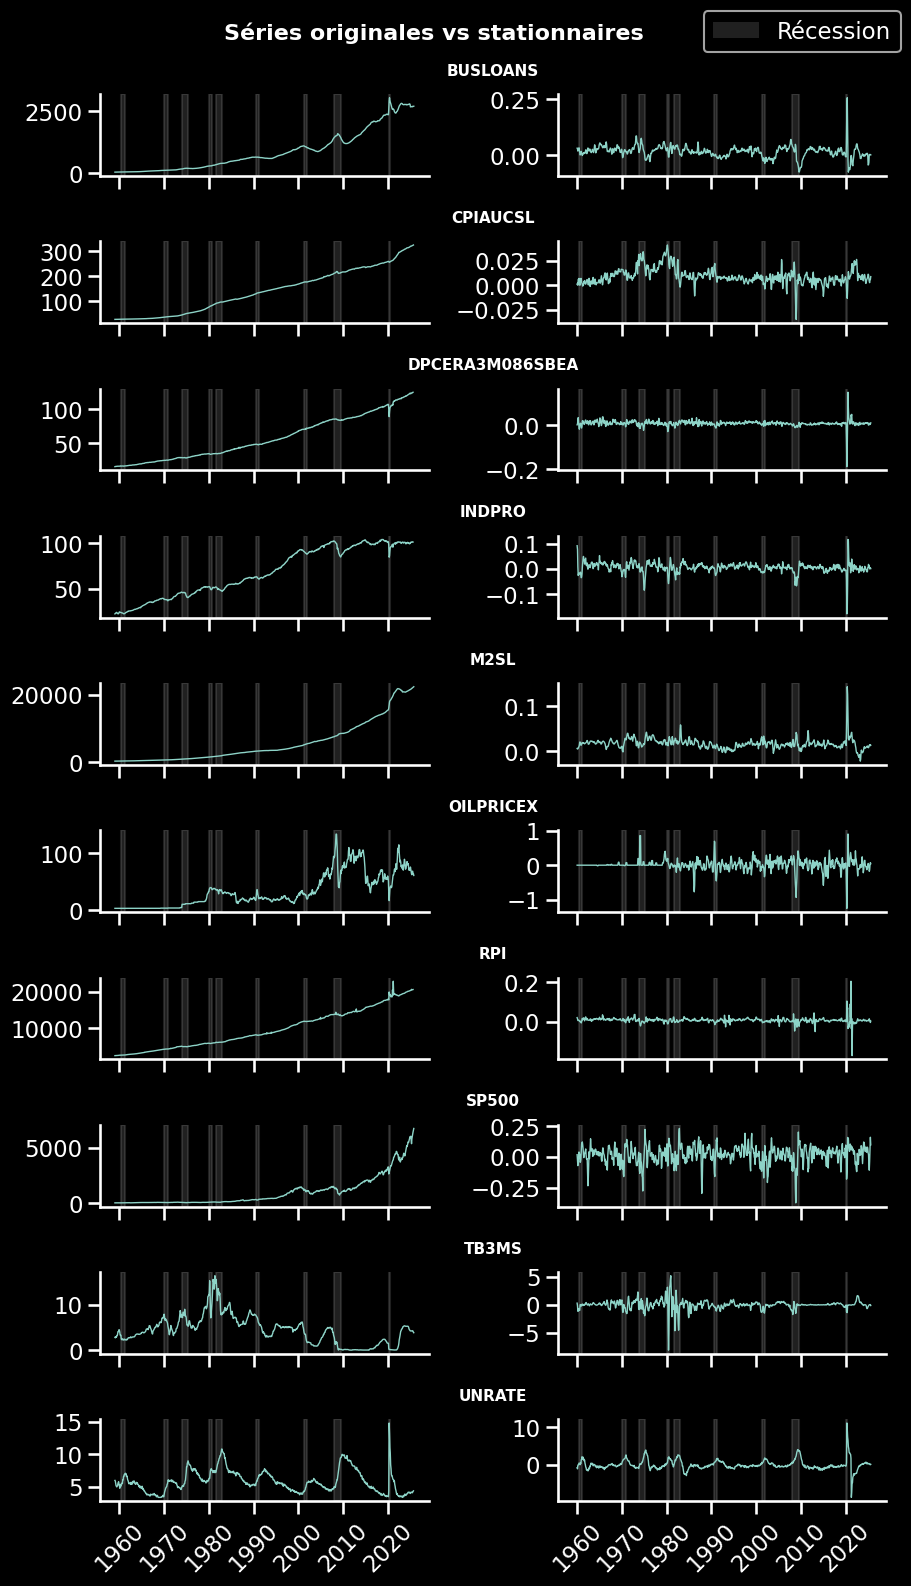

In [101]:
df_plot = plot_original_vs_stationary_side_by_side(
    df_original=df,
    df_stationary=df_stationary,
    linewidth=1.0,
    style="dark_background",
    sharey=False
)

Nous constatons que les transformations appliquées ont bien fonctionné. La tendance (ou drift) a été supprimée et les séries sont désormais stationnaires. Elles oscillent autour d’une moyenne proche de zéro, sans dérive apparente. 

A titre de remarque, la récession impacte d'une manière ou d'une autre chaque variable.